# Convolution Image Net

 - conv 33132, relu, max_pool 1221
 - add conv summary
 - check reshape
 - droput feed forward (keep_prob variable)
 - conv 333262
 - batch norm + with statement + is_training placeholder
 - check results, compare them
 - run with mscoco

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import os
import shutil
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from PIL import Image
from utils.nn_graph import simple_layer
from utils.data import init_dir

## Load data

In [3]:
data = input_data.read_data_sets('/data/fashion/', one_hot=True)
img_shape = (28, 28)
class_id2class_name_mapping = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'}

Extracting /data/fashion/train-images-idx3-ubyte.gz
Extracting /data/fashion/train-labels-idx1-ubyte.gz
Extracting /data/fashion/t10k-images-idx3-ubyte.gz
Extracting /data/fashion/t10k-labels-idx1-ubyte.gz


## Build Conv Net Graph

In [4]:
from utils.nn_visualization import conv33132_summaries, conv55124_summary, variable_summaries

In [5]:
graph = tf.Graph()
with graph.as_default():
    with tf.name_scope('conv_image_net_inputs'):
        images = tf.placeholder(tf.float32, shape=[None, 784], name='images')
        labels = tf.placeholder(tf.float32, shape=[None, 10], name='labels')
        keep_dropout_prob = tf.placeholder(tf.float32, name='keep_dropout_prob')
        is_training = tf.placeholder(tf.bool, name='is_training')
            
    with tf.name_scope('image_reshape'):        
        images_reshaped = tf.reshape(images, [-1, 28, 28, 1])

    with tf.variable_scope('conv_layer_1'):
        w_conv_1 = tf.get_variable('w_conv_1', [3, 3, 1, 32], initializer=tf.contrib.layers.variance_scaling_initializer())
        b_conv_1 = tf.get_variable('b_conv_1', initializer=tf.constant_initializer(0), shape=[32])
        conv33132_summaries('w_conv_1_summary', w_conv_1)

        conv_layer_1 = tf.nn.conv2d(images_reshaped, w_conv_1, strides=[1, 1, 1, 1], padding='SAME')
        #conv_layer_1 = tf.contrib.layers.batch_norm(conv_layer_1, is_training=is_training)
        conv_layer_1 = conv_layer_1 + b_conv_1
        conv_layer_1 = tf.nn.relu(conv_layer_1)
        conv_layer_1 = tf.nn.max_pool(conv_layer_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')   

    with tf.variable_scope('conv_layer_2'):
        w_conv_2 = tf.get_variable('w_conv_2', [3, 3, 32, 64], initializer=tf.contrib.layers.variance_scaling_initializer())
        b_conv_2 = tf.get_variable('b_conv_2', initializer=tf.constant_initializer(0), shape=[64])
  
        conv_layer_2 = tf.nn.conv2d(conv_layer_1, w_conv_2, strides=[1, 1, 1, 1], padding='SAME')
        #conv_layer_2 = tf.contrib.layers.batch_norm(conv_layer_2, is_training=is_training)
        conv_layer_2 = conv_layer_2 + b_conv_2
        conv_layer_2 = tf.nn.relu(conv_layer_2)
        conv_layer_2 = tf.nn.max_pool(conv_layer_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    with tf.variable_scope('feed_forward_layer_1'):
        ff_layer_1 = tf.reshape(conv_layer_2, [-1, 7*7*64])
        ff_layer_1 = simple_layer('ff_1', ff_layer_1, shape=[7*7*64, 10], activation='linear')
        raw_prediction = tf.nn.dropout(ff_layer_1, keep_dropout_prob)
    
    with tf.name_scope('prediction'):
        prediction = tf.nn.softmax(raw_prediction)
    
    with tf.variable_scope("embedding_visualization"):
        embedding = tf.Variable(tf.zeros([5000, 10]), name='valid_embedding')
        embedding_assignment = embedding.assign(raw_prediction)

    with tf.name_scope('loss'):
        cross_entropy_vector = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=raw_prediction)
        loss = tf.reduce_mean(cross_entropy_vector)
        variable_summaries('loss_summary', cross_entropy_vector)
        
    with tf.name_scope('training'):
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_step  = tf.train.AdamOptimizer(1e-4).minimize(loss)

    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        accuracy = tf.reduce_mean(correct_prediction)
        variable_summaries('accuracy_summary', correct_prediction)
    
    initialize_vars = tf.global_variables_initializer()
    merge_summaries = tf.summary.merge_all()

## Init Model Logging

In [27]:
from utils.data import init_model_logging
base_dir = '/tensorboard_summaries/conv_image_net/'
exp_name = 'experiment_1'

logging_meta = init_model_logging(base_dir, exp_name, graph=graph, remove_existing=True)

## Add Embedding Projection

In [26]:
from utils.nn_visualization import init_embedding_projector, init_embedding_data
from utils.nn_visualization import get_sprite_img, get_label_class_names

sprite_img = get_sprite_img(data.validation.images, img_shape)
label_names = get_label_class_names(data.validation.labels, class_id2class_name_mapping)

init_embedding_data(logging_meta['valid_writer_dir'], sprite_img, label_names)
init_embedding_projector(logging_meta['valid_writer'], embedding, img_shape)

## Run Conv Net

In [16]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
model_path = logging_meta['model_path']
  
validation_feed_dict = {
    images: data.validation.images, 
    labels: data.validation.labels,
    keep_dropout_prob: 1., 
    is_training: False}

with tf.Session(graph=graph, config=config) as session:
    session.run(initialize_vars)
    for iteration in range(1000):
        _images, _labels = data.train.next_batch(100)
        
        feed_dict={images: _images, 
                   labels: _labels, 
                   keep_dropout_prob: 0.5, 
                   is_training: True}
        _ = session.run([train_step], feed_dict)
        

        if iteration % 10 == 0:
            feed_dict={images: _images, 
                       labels: _labels,
                       keep_dropout_prob: 1., 
                       is_training: False}
            _summary, = session.run([merge_summaries], feed_dict)
            logging_meta['train_writer'].add_summary(_summary, iteration)
            
        if iteration % 100 == 0:
            fetches = [embedding_assignment, merge_summaries, accuracy, loss]
            _, _summary, _accuracy, _loss = session.run(fetches, validation_feed_dict)
            logging_meta['valid_writer'].add_summary(_summary, iteration)
            logging_meta['saver'].save(session, model_path, iteration)
            print("Iteration {}: loss {}, accuracy {}".format(iteration, _loss, _accuracy))
            
    _prediction, = session.run([prediction], validation_feed_dict)

Iteration 0: loss 2.3585846424102783, accuracy 0.1817999929189682
Iteration 100: loss 1.1967929601669312, accuracy 0.7170000076293945
Iteration 200: loss 0.9197831749916077, accuracy 0.7771999835968018
Iteration 300: loss 0.7921609282493591, accuracy 0.7925999760627747
Iteration 400: loss 0.7244911789894104, accuracy 0.8148000240325928
Iteration 500: loss 0.6696695685386658, accuracy 0.8194000124931335
Iteration 600: loss 0.6276196837425232, accuracy 0.8294000029563904
Iteration 700: loss 0.6027511954307556, accuracy 0.8378000259399414
Iteration 800: loss 0.564536452293396, accuracy 0.843999981880188
Iteration 900: loss 0.5530091524124146, accuracy 0.8485999703407288


## Results evaluation

In [17]:
from utils.results_evaluation import get_info_df
from utils.results_evaluation import get_accuracy
from utils.results_evaluation import get_false_positives
from utils.results_evaluation import get_info_df
from utils.results_evaluation import get_rec_prec
from utils.results_evaluation import plot_coocurance_matrix
from utils.results_evaluation import plot_examples 

In [18]:
df = get_info_df(data.validation.labels, _prediction, class_id2class_name_mapping, data.validation.images)

In [19]:
get_accuracy(df)

85.14

In [20]:
get_accuracy(df, True)

97.98

In [21]:
get_rec_prec(df, class_id2class_name_mapping)

,class_name,precision,recall
0,T-shirt/top,70.27,86.87
1,Trouser,96.60,97.12
2,Pullover,72.58,78.77
3,Dress,86.96,87.82
4,Coat,72.41,86.07
5,Sandal,88.67,98.38
6,Shirt,75.52,36.92
7,Sneaker,97.56,85.94
8,Bag,96.23,93.88
9,Ankle boot,94.30,98.02


In [22]:
fp = get_false_positives(df, 'Shirt')

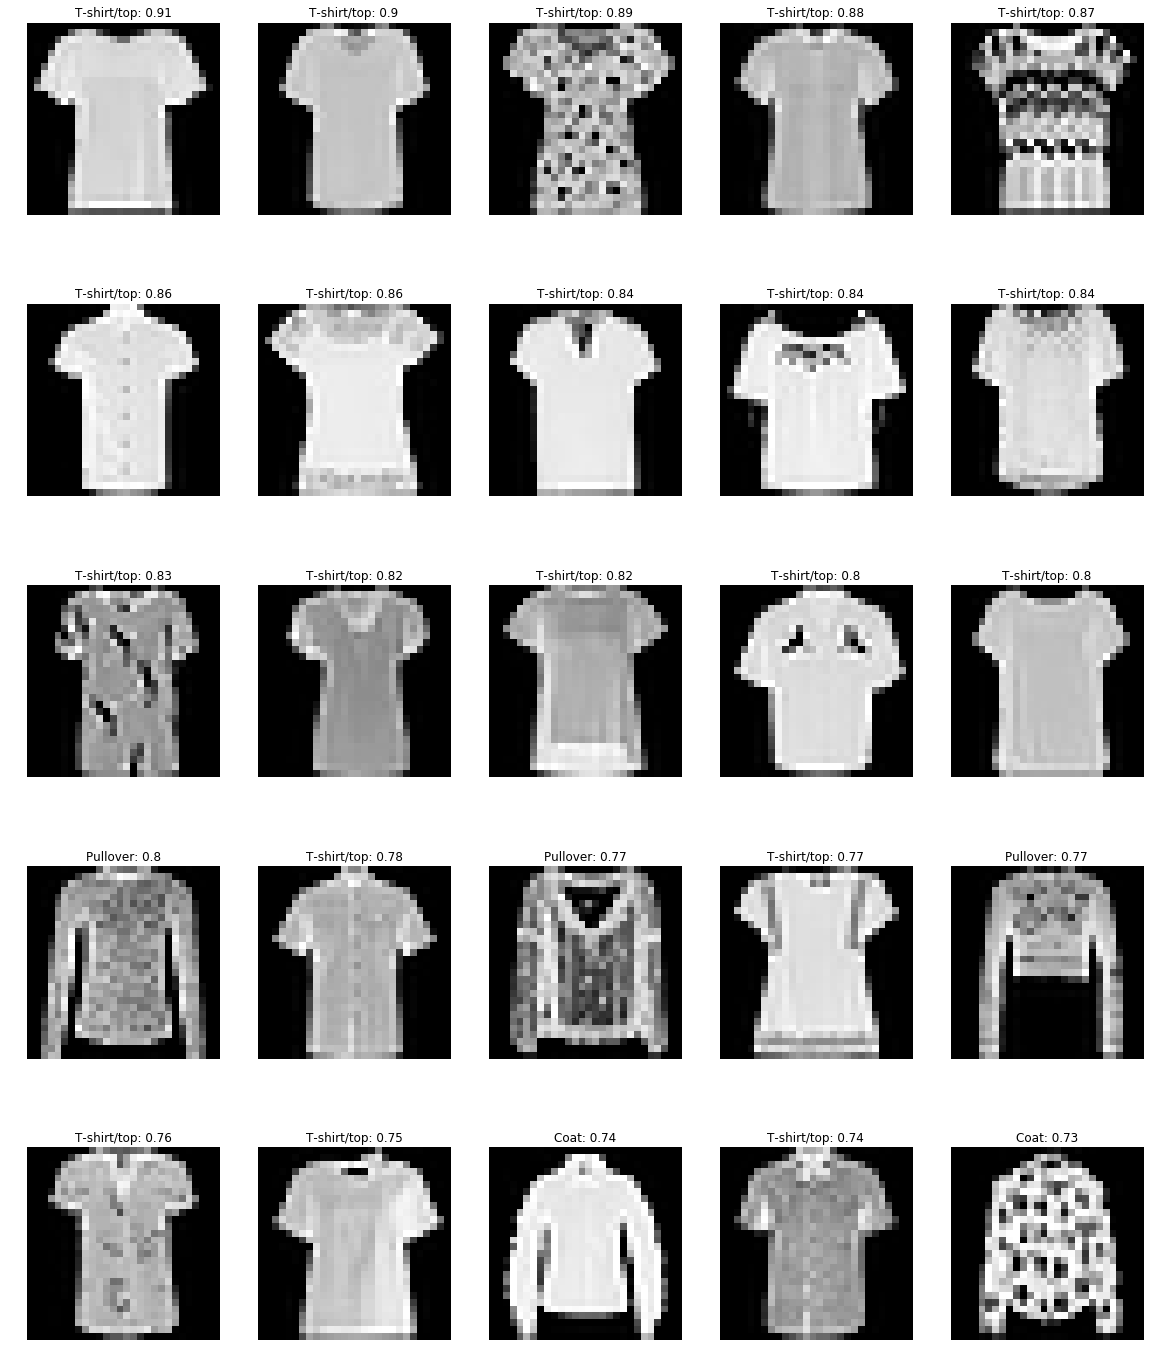

In [23]:
plot_examples(fp)

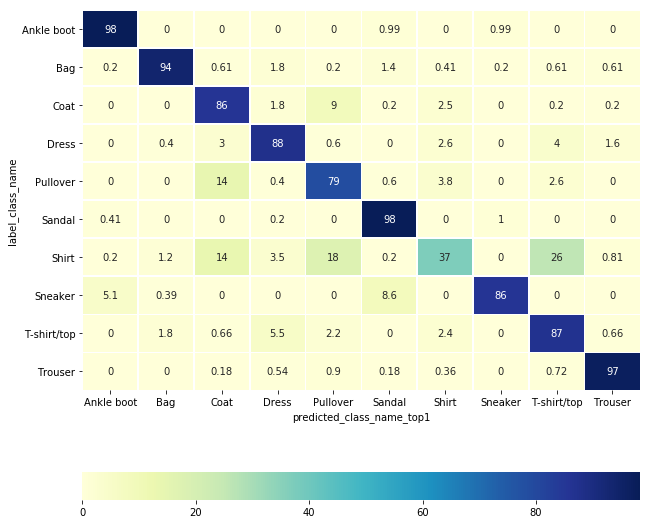

In [24]:
plot_coocurance_matrix(df, use_top3=False, use_log=False)